Lets first see if the GPU is enabled. If it isn't, you need to enabled it in google colab

In [1]:
!nvidia-smi

Thu Jan  4 17:12:37 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

We will use google drive for this task. You need to accept the connection after the below code line is executed.

In [14]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


You will need to copy the folder key_padlock_detection_data into your google drive. The below line unzips the dataset containing images and annotations.

In [3]:
!unzip "/content/gdrive/MyDrive/key_padlock_detection_data/zip/images_and_annotations.zip" -d "/content/gdrive/MyDrive/key_padlock_detection_data"

Archive:  /content/gdrive/MyDrive/key_padlock_detection_data/zip/images_and_annotations.zip
  inflating: /content/gdrive/MyDrive/key_padlock_detection_data/images_and_annotations/key_or_padlock (1).jpg  
  inflating: /content/gdrive/MyDrive/key_padlock_detection_data/images_and_annotations/key_or_padlock (1).txt  
  inflating: /content/gdrive/MyDrive/key_padlock_detection_data/images_and_annotations/key_or_padlock (10).jpg  
  inflating: /content/gdrive/MyDrive/key_padlock_detection_data/images_and_annotations/key_or_padlock (10).txt  
  inflating: /content/gdrive/MyDrive/key_padlock_detection_data/images_and_annotations/key_or_padlock (100).jpg  
  inflating: /content/gdrive/MyDrive/key_padlock_detection_data/images_and_annotations/key_or_padlock (100).txt  
  inflating: /content/gdrive/MyDrive/key_padlock_detection_data/images_and_annotations/key_or_padlock (101).jpg  
  inflating: /content/gdrive/MyDrive/key_padlock_detection_data/images_and_annotations/key_or_padlock (101).txt  
  

Lets now create train and test. First, lets see all files contained in the folder images_and_annotations

In [4]:
from os import listdir
from os.path import isfile, join

mypath = "/content/gdrive/MyDrive/key_padlock_detection_data/images_and_annotations"
imagepaths = [f for f in listdir(mypath) if isfile(join(mypath, f))]
imagepaths = list(mypath + "/" + img for img in imagepaths)

In [5]:
len(imagepaths)

394

We have 394 files. Lets just make sure every file has an annotation:

In [6]:
for imagepath in imagepaths:
  name = imagepath[:-3]
  jpg = name + "jpg"
  txt = name + "txt"
  if (jpg not in imagepaths):
    print(jpg)
  if (txt not in imagepaths):
    print(txt)

If there is no error, lets extract only the image files.

In [7]:
jpg_imagepaths = list(filter(lambda path: ".jpg" in path, imagepaths))
print(len(jpg_imagepaths))

197


We have 197 of those.


Below, we define a function that split a list into some ratio. We will use it to split train and test.

In [8]:
def list_splitter(list_to_split, ratio):
    elements = len(list_to_split)
    middle = int(elements * ratio)
    return [list_to_split[:middle], list_to_split[middle:]]

Now, we split train and test. We could also shuffle the data, but the data is randomly ordered, so there is no real need to do this. The split ratio is 80% for train and 20% for test.

In [9]:
train_images, test_images = list_splitter(jpg_imagepaths, 0.8)
print(len(train_images))
print(len(test_images))

157
40


Now, lets create the files train.txt and test.txt, which one containt the paths of all train and test images

In [10]:
with open("/content/gdrive/MyDrive/key_padlock_detection_data/train.txt", 'w') as f:
    for i, train_image in enumerate(train_images):
      f.write(train_image)
      if (i < len(train_images) - 1):
        f.write("\n")

In [11]:
with open("/content/gdrive/MyDrive/key_padlock_detection_data/test.txt", 'w') as f:
    for i, test_image in enumerate(test_images):
      f.write(test_image)
      if (i < len(test_images) - 1):
        f.write("\n")

Now we will start the training process. We need to clone the darknet repository

In [2]:
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 15833, done.
remote: Total 15833 (delta 0), reused 0 (delta 0), pack-reused 15833
Receiving objects: 100% (15833/15833), 14.39 MiB | 15.02 MiB/s, done.
Resolving deltas: 100% (10666/10666), done.


Prepare to make

In [3]:
%cd darknet

/content/darknet


In [4]:
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile

In [5]:
# Make file
"/content/darknet/Makefile"

'/content/darknet/Makefile'

In [6]:
!make

mkdir -p ./obj/
mkdir -p backup
mkdir -p results
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -DCUDNN_HALF -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -rdynamic -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -DCUDNN_HALF -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:945:23: warning: variable ‘rgb’ set but not used []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Options.html#index-Wunused-but-set-variable-Wunused-but-set-variable]8;;]
  945 |                 float rgb[3];
      |                       ^~~
./src/image_opencv.cpp: In function ‘void cv_draw_object(image, float*, int, int, int*, float*, int*, int, char**)’:
./src/image_opencv.cpp:1443:14: wa

In [7]:
# Download weights
!wget https://pjreddie.com/media/files/darknet53.conv.74

--2024-01-04 18:01:18--  https://pjreddie.com/media/files/darknet53.conv.74
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162482580 (155M) [application/octet-stream]
Saving to: ‘darknet53.conv.74’

darknet53.conv.74   100%[===================>] 154.96M  29.3MB/s    in 7.2s    

2024-01-04 18:01:25 (21.7 MB/s) - ‘darknet53.conv.74’ saved [162482580/162482580]



Lets update the coco.names file with our labels:

In [12]:
with open("/content/darknet/data/coco.names", 'w') as f:
  f.write("Key\nPadlock")

Now, we simply run the following line to train the model.

In [ ]:
!./darknet detector train /content/gdrive/MyDrive/key_padlock_detection_data/detector.data /content/gdrive/MyDrive/key_padlock_detection_data/cfg/yolov3-custom.cfg darknet53.conv.74 -dont_show

A saída de streaming foi truncada nas últimas 5000 linhas.
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 94 Avg (IOU: 0.590877), count: 2, class_loss = 0.400673, iou_loss = 0.411961, total_loss = 0.812634 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 106 Avg (IOU: 0.000000), count: 1, class_loss = 0.003974, iou_loss = 0.000000, total_loss = 0.003974 
 total_bbox = 185504, rewritten_bbox = 0.381663 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (IOU: 0.771069), count: 2, class_loss = 0.150891, iou_loss = 0.084854, total_loss = 0.235745 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 94 Avg (IOU: 0.684043), count: 15, class_loss = 1.119074, iou_loss = 1.342897, total_loss = 2.461971 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 106 Avg (IOU: 0.000000), count: 1, class_loss = 0.002859, iou_loss = 0.000000, total_loss = 0.002859 
 total_bbox = 185521, rewritten_bbox = 0.381628

We could run the following line if the training process somehow stopped. Change the last argument before "-dont_show" to setup the weight file location from where the model should continue the training.

In [8]:
#!./darknet detector train /content/gdrive/MyDrive/key_padlock_detection_data/detector.data /content/gdrive/MyDrive/key_padlock_detection_data/cfg/yolov3-custom.cfg /content/gdrive/MyDrive/key_padlock_detection_data/backup/yolov3-custom_last.weights -dont_show

 CUDA-version: 12020 (12020), cuDNN: 8.9.6, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 4.5.4
yolov3-custom
 0 : compute_capability = 750, cudnn_half = 1, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 4, batch = 64, time_steps = 1, train = 1 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 

To use the trained model to run on some image, we run the following line of code:

(You can change the location "/content/gdrive/MyDrive/key_padlock_detection_data/backup/yolov3-custom_last.weights" to the location of the weights file you want to use).

In [36]:
!./darknet detect /content/gdrive/MyDrive/key_padlock_detection_data/cfg/yolov3-custom.cfg /content/gdrive/MyDrive/key_padlock_detection_data/backup/yolov3-custom_last.weights /content/gdrive/MyDrive/key_padlock_detection_data/demonstration_images/example3.jpg -dont-show

 CUDA-version: 12020 (12020), cuDNN: 8.9.6, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 4.5.4
 0 : compute_capability = 750, cudnn_half = 1, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.59

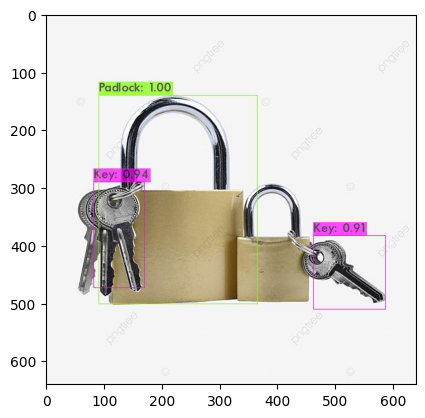

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread("/content/darknet/predictions.jpg")
imgplot = plt.imshow(img)
plt.show()